In [1]:
import time
import os
import sys
import csv
import json
import shutil
import random
import pprint
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models

sys.path.insert(1, 'HelperScripts')
from HelperFunctions import *
from pytorch_resnet import *
from randaugment import RandAugmentMC

os.environ["WANDB_SILENT"] = "true"
import wandb
wandb.login()
#%env "WANDB_NOTEBOOK_NAME" "Baseline Training"

True

In [2]:
device_name = torch.cuda.get_device_name(0)
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

transform_test = transforms.Compose([
            transforms.ToTensor()
])

Green
Number of testing examples: 833
{'Basophil': 0, 'Eosonophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
[0, 1, 2, 3, 4]
Loading weights from: Models/baseline/temp/Greenmobilenet_v2_profiling_Green.pt
Fusing mobilenet_v2...
Quantizing mobilenet_v2...
Converting mobilenet_v2...
Saving quantized mobilenet_v2...


C:\Users\zarre\.conda\envs\gpu\lib\site-packages\torch\ao\quantization\utils.py:156: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


Purple
Number of testing examples: 833
{'Basophil': 0, 'Eosonophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
[0, 1, 2, 3, 4]
Loading weights from: Models/baseline/temp/Purplemobilenet_v2_profiling_Purple.pt
Fusing mobilenet_v2...
Quantizing mobilenet_v2...
Converting mobilenet_v2...
Saving quantized mobilenet_v2...


C:\Users\zarre\.conda\envs\gpu\lib\site-packages\torch\ao\quantization\utils.py:156: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


Red
Number of testing examples: 833
{'Basophil': 0, 'Eosonophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
[0, 1, 2, 3, 4]
Loading weights from: Models/baseline/temp/Redmobilenet_v2_profiling_Red.pt
Fusing mobilenet_v2...
Quantizing mobilenet_v2...
Converting mobilenet_v2...
Saving quantized mobilenet_v2...


C:\Users\zarre\.conda\envs\gpu\lib\site-packages\torch\ao\quantization\utils.py:156: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


Fluor
Number of testing examples: 833
{'Basophil': 0, 'Eosonophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}
[0, 1, 2, 3, 4]
Loading weights from: Models/baseline/temp/Fluormobilenet_v2_profiling_Fluor.pt
Fusing mobilenet_v2...
Quantizing mobilenet_v2...
Converting mobilenet_v2...
Saving quantized mobilenet_v2...


C:\Users\zarre\.conda\envs\gpu\lib\site-packages\torch\ao\quantization\utils.py:156: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


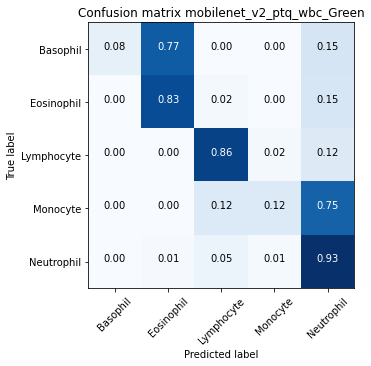

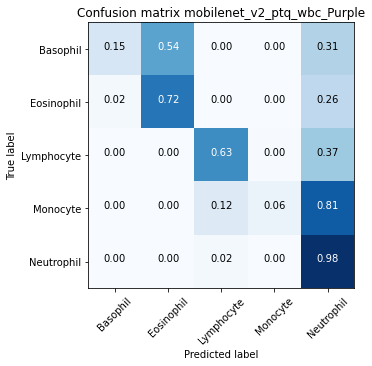

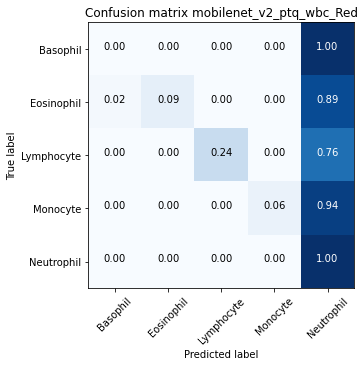

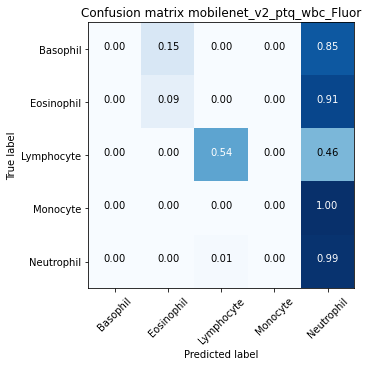

In [3]:
for colour in ['Green','Purple','Red','Fluor']:
    print(colour)
#'green','red','purple','fluor'
    config_ptq = dict(
        classes=['Basophil','Eosinophil','Lymphocyte','Monocyte','Neutrophil'],
        quant_type = 'PTQ',
        observer = ['MovingAverageMinMaxObserver','MinMaxObserver'],
        dtype = ["quint8", "quint8"],
        qscheme = ['per_tensor_affine', 'per_tensor_symmetric'],
        reduce_range = ["False", "False"],
        image_size=160,
        batch_size=32,
        batch_size_latency=1,
        save = 'Models/baseline/temp/'+ colour,
        save_suffix = "_ptq_wbc_"+colour,
        load_suffix = '_profiling_'+colour,
        #test_set = colour + '_test',
        architecture_list = [#'resnet18',
                             # 'resnet34',
                             # 'resnet50', 
                             # 'regnet_y_400mf',
                             #'mobilenet_v3_small'
                             'mobilenet_v2',
                             # 'shufflenet_v2_x0_5',
                             # 'regnet_x_400mf',
                             # 'regnet_x_800mf',
                             # 'regnet_y_400mf',
                             # 'regnet_y_800mf'
                             ],
        data_path = 'T:/Haematology FYP/Data/WBC_Classification_3172_c/',
        tags = [colour,'PTQ','v3'],
        logging = 'online'#'disabled' #
    )
    test_data = datasets.ImageFolder(config_ptq['data_path'] + colour + '/test', transform=transform_test)
    print(f'Number of testing examples: {len(test_data)}')
    test_loader = dataloader(test_data, batch_size=config_ptq['batch_size'], pin_memory=True, drop_last=True)
    print(test_data.class_to_idx)
    torch.unique(torch.FloatTensor(test_data.targets), return_counts=True)
    print(list(test_data.class_to_idx.values()))

    for architecture in config_ptq['architecture_list']:
        with wandb.init(project="Baseline Training", config=config_ptq, group="PTQ", tags=config_ptq['tags'], job_type='eval', reinit=True, mode=config_ptq['logging']):
            wandb.config['architecture'] = architecture
            wandb.run.summary['architecture'] = architecture
            wandb.config['colour'] = colour
            config = wandb.config
            wandb.run.name = config['architecture']+config['save_suffix']
            float_model_file = config['save']+architecture+config['load_suffix']+'.pt'
            if architecture in ['resnet18','resnet34','resnet50']:
                model = load_model(architecture).to(cpu_device).eval()
            elif architecture in ['regnet_y_400mf']:
                model = create_model(architecture, cpu_device)
                #model = CustomRegNet()
            elif architecture in ['mobilenet_v3_small']:
                model = create_model(architecture, cpu_device)
            elif architecture == 'mobilenet_v2':
                model = MobileNetV2(num_classes=5)
            #num_ftrs = model.fc.in_features
            #model.fc = nn.Linear(num_ftrs, 5).to(cpu_device)
            print('Loading weights from: {}'.format(float_model_file))
            check_point = torch.load(float_model_file)
            model.load_state_dict(check_point['model_state_dict'])
            model.to(cpu_device)
            model.eval()
            loss_fn = nn.CrossEntropyLoss()
            before = latency_test(model,cpu_device,repetitions=30,batch_size=1,num_threads=0)

            #Fuse model (conv+batchnorm+relu)
            print('Fusing {}...'.format(architecture))
            if architecture in ['resnet18','resnet34','resnet50']:
                model = model_fusion(model, architecture)
            elif architecture in ['regnet_y_400mf']:
                fusion_regnet(model)
            elif architecture in ['mobilenet_v3_small']:
                #model = create_model(architecture, cpu_device)
                pass
            elif architecture == 'mobilenet_v2':
                model.fuse_model()
            
            #Quantization
            print('Quantizing {}...'.format(architecture))
            quantization_config = torch.quantization.QConfig(
                activation=getattr(torch.quantization, config['observer'][0]).with_args(dtype=torch.quint8, qscheme=getattr(torch, config['qscheme'][0])),
                weight=getattr(torch.quantization, config['observer'][1]).with_args(dtype=torch.qint8, qscheme=getattr(torch, config['qscheme'][1])))
            model.qconfig = quantization_config
            torch.quantization.prepare(model, inplace=True)
            
            evaluate_cal(model, loss_fn, test_loader, neval_batches=50)
            # Convert to quantized model
            print('Converting {}...'.format(architecture))
            model = torch.quantization.convert(model, inplace=True)
            #Save Model
            print('Saving quantized {}...'.format(architecture))
            torch.save(model.state_dict(), config['save']+architecture+config['load_suffix'])
            #Evaluation
            model.eval()
            #Model size
            wandb.run.summary['Model Size'] = size_measure(model)
            #Measure Accuracy
            loss_fn = nn.CrossEntropyLoss().to(cpu_device)
            results, cm = evaluate2(model=model, device=cpu_device, loader=test_loader, batch_size=config['batch_size'], loss_fun=loss_fn, labels_indx=list(test_data.class_to_idx.values()), names=list(test_data.class_to_idx.keys()))
            # sample_weight=torch.unique(torch.FloatTensor(test_data.targets),return_counts=True)[1].tolist()
            #pprint.pprint(results)
            wandb.run.summary['CM'] = cm
            wandb.log({'CM Plot' : wandb.Image(return_cm(cm, config['classes'], normalize=True, title='Confusion matrix '+ config['architecture'] + config['save_suffix'], cmap=plt.cm.Blues))})
            wandb.run.summary['Results'] = results
            #Measure Latency
            time_logger, std_logger, time2_logger = latency_test(model, cpu_device, repetitions=300, batch_size=config['batch_size_latency'], num_threads=0)
            wandb.run.summary['Inference Time'] = {'CUDA':time_logger,'Std':std_logger,'CPU':time2_logger}
            wandb.run.summary['Acc/Time'] = results['accuracy']/time_logger
            wandb.run.summary['Macro F1/Time'] = results['macro avg']['f1-score']/time_logger
            #print_measurements(config['classes'],precision,sensitivity,f1,acc,cm,wandb.run.summary['Model Size'],time_logger,time2_logger)
            #clear_output(wait=True)
            